In [2]:
import binascii
import os
import pickle
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from tqdm import tnrange
from __future__ import print_function
import chipwhisperer as cw
from chipwhisperer.tests.tools_for_tests import FIRMWARE_DIR
from chipwhisperer.capture.api.programmers import XMEGAProgrammer

In [3]:
# Notebook settings
%matplotlib notebook

In [4]:
scope = cw.scope()
target = cw.target(scope)

In [5]:
# setup scope parameters
scope.gain.gain = 45
scope.adc.samples = 3000
scope.adc.offset = 0
scope.adc.basic_mode = "rising_edge"
scope.clock.clkgen_freq = 7370000
scope.clock.adc_src = "clkgen_x4"
scope.trigger.triggers = "tio4"
scope.io.tio1 = "serial_rx"
scope.io.tio2 = "serial_tx"
scope.io.hs2 = "clkgen"

In [6]:
firmware_dir = os.path.abspath(os.path.join(FIRMWARE_DIR, 'simpleserial-aes'))
hex_file = os.path.join(firmware_dir, r'simpleserial-aes-CW303.hex')
programmer = XMEGAProgrammer()
programmer.scope = scope
programmer._logging = None
programmer.find()
programmer.erase()
programmer.program(hex_file, memtype="flash", verify=True)
programmer.close()

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 3481 bytes


In [7]:
HW = [bin(n).count("1") for n in range(0,256)]
sbox=(
0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16)

def intermediate(ptb, keyb):
    return sbox[ptb ^ keyb]
def calculateTracesHW(subkey, traces, textins, keys):
    tnum = len(traces)
    tracesHW = [[] for _ in range(9)]
    for t in range(tnum):
        hw = HW[intermediate(textins[t][subkey], keys[t][subkey])]
        tracesHW[hw].append(traces[t])        
    # Convert to a pure np array
    tracesHW = [np.array(ttrace) for ttrace in tracesHW]
    return tracesHW
def calculateMeantraces(traces):
    tracelen = len(traces[0][0])
    meantraces = np.zeros((9, tracelen))
    for i in range(9):
        meantraces[i] = np.average(traces[i], 0)
    return meantraces
def cov(x, y):
    return np.cov(x,y)[0][1]
def computeCovMatrices(tracesHW, meantraces, POIs):
    POInum = len(POIs)
    meanMatrix = np.zeros((9, POInum))
    for hw in range(9):
        for i, poi in enumerate(POIs):
            meanMatrix[hw][i] = meantraces[hw][poi]
    covMatrix  = np.zeros((9, POInum, POInum))
    for hw in range(9):
        for i, poii in enumerate(POIs):
            for j, poij in enumerate(POIs):
                x = tracesHW[hw][:,poii]
                y = tracesHW[hw][:,poij]
                covMatrix[hw,i,j] = cov(x, y) 
    return (meanMatrix, covMatrix)
def calculateSumDiff(traces):
    tracelen = len(traces[0])
    tempSumDiff = np.zeros(tracelen)
    for i in range(9):
        for j in range(i):
            tempSumDiff += np.abs(traces[i] - traces[j])
    return tempSumDiff
def calcSboxCorr(trcs,inps,keys,byte):
    ntrc = len(trcs)
    ltrc = len(trcs[0])
    rs   = []
    for off in range(ltrc):
        a = []
        b = []
        for i in range(ntrc):
            x = keys[i][byte]
            y = inps[i][byte]
            z = x^y
            z = sbox[z]
            a.append(HW[z])
            b.append(trcs[i][off])
        rs.append(abs(np.corrcoef(a,b)[1,0]))
    return np.nan_to_num(rs, copy=False)
def findPOIs(spikes, num=5, space=5, incr=0):
    spikes = spikes.copy()
    spikes[:1300] = 0
    spikes[2900:] = 0
    POIs = []
    # Repeat until we have enough POIs
    for _ in range(num):
        # Find the biggest peak and add it to the list of POIs
        nextPOI = spikes.argmax()
        POIs.append(nextPOI)
        # Zero out some of the surrounding points
        # Make sure we don't go out of bounds
        poiMin = max(0, nextPOI - space)
        poiMax = min(nextPOI + space, len(spikes))
        for j in range(poiMin, poiMax):
            spikes[j] = 0
        space += incr
    return POIs
def getone(txi,key):
    target.reinit()
    target.loadEncryptionKey(key)
    target.loadInput(txi)
    scope.arm()
    target.go()
    timeout = 50
    while target.isDone() is False and timeout > 0:
        timeout -= 1
        time.sleep(0.01)
    try:
        ret = scope.capture()
        if ret:
            print('Timeout happened during acquisition')
    except IOError as e:
        print('IOError: %s' % str(e))
    txo = target.readOutput()
    trc = scope.getLastTrace()
    return (txo,trc)
def plotmeatrace(fignum, trace, title=None):
    plt.figure()
    if title:
        plt.title(title)
    plt.plot(trace)
    plt.grid()
    plt.show()
def plot(x):
    plt.figure()
    for i in x:
        plt.plot(i)
    plt.show()
def guessSubkey(subkey, attack_traces, attack_textins, POIs, meanMatrix, covMatrix):
    P_k =  np.zeros(256)
    for j in range(len(attack_traces)):
        # Grab key points and put them in a matrix
        a = [attack_traces[j][poi] for poi in POIs]

        # Test each key
        for k in range(256):
            # Find HW coming out of sbox
            hw = HW[intermediate(attack_textins[j][subkey], k)]

            # Find p_{k,j}
            rv = multivariate_normal(meanMatrix[hw], covMatrix[hw])
            p_kj = rv.pdf(a)

            # Add it to running total
            P_k[k] += np.log(p_kj)
    return P_k.argsort()[::-1]

In [8]:
tpl_trcs = []
tpl_keys = []
tpl_txis = []
tpl_txos = []
target.init()
for i in tnrange(8*1024, desc='Capturing traces'):
    key = '{:032x}'.format(random.getrandbits(128))
    txi = '{:032x}'.format(random.getrandbits(128))
    (txo, trc) = getone(txi,key)
    txi = bytearray.fromhex(txi)
    key = bytearray.fromhex(key)
    tpl_txis.append(np.asarray(txi, dtype=np.uint8))
    tpl_txos.append(np.asarray(txo, dtype=np.uint8))
    tpl_trcs.append(np.asarray(trc, dtype=np.float64))
    tpl_keys.append(np.asarray(key, dtype=np.uint8))

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdDYXB0dXJpbmcgdHJhY2VzJywgbWF4PTgxOTIsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb27igKY=


In [9]:
# Export numpy traces
with open('template_traces.pic', 'wb') as output:
    pickle.dump((tpl_trcs, tpl_keys, tpl_txis, tpl_txos), output)

In [10]:
# Import numpy traces
with open('template_traces.pic', 'rb') as input:
    (tpl_trcs, tpl_keys, tpl_txis, tpl_txos) = pickle.load(input)

Trace length: 3000 
Text In:      f168f78411ca6f535f6857f2aaf848c6 
Text Out:     b389f7c85ad3f815f771d395a762d32a


<IPython.core.display.Javascript object>


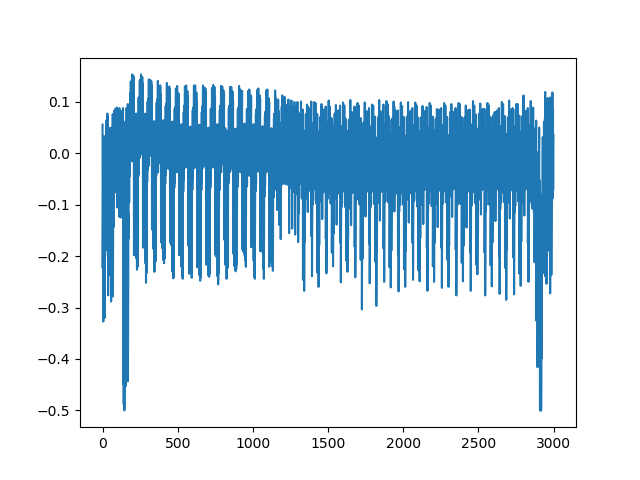

In [11]:
# Make sure we got a correct-looking trace
print('Trace length:', len(tpl_trcs[0]),'\n'
      'Text In:     ', binascii.hexlify(tpl_txis[0]).decode(),'\n'
      'Text Out:    ', binascii.hexlify(tpl_txos[0]).decode())
plt.figure()
plt.plot(tpl_trcs[0])
plt.show()

<IPython.core.display.Javascript object>


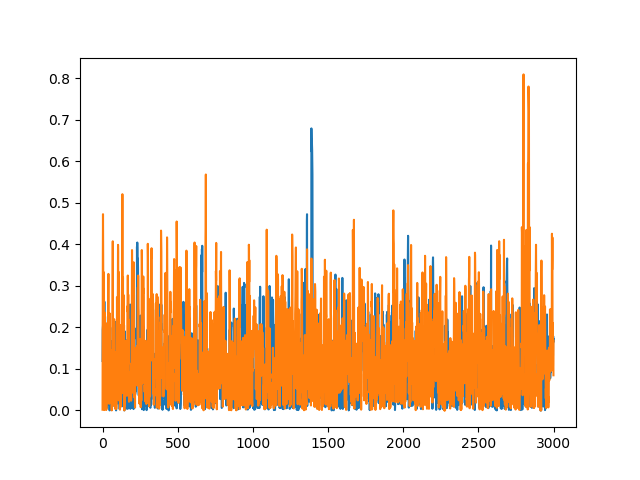

In [14]:
# Make sure we got sbox correlations in trace range
plt.figure()
plt.plot(calcSboxCorr(tpl_trcs[0:50],tpl_txis[0:50],tpl_keys[0:50],0))
plt.plot(calcSboxCorr(tpl_trcs[0:50],tpl_txis[0:50],tpl_keys[0:50],15))
plt.show()

In [18]:
#Make sure we have "enough" template traces for all subkeys and hamming weights
for i in range(16):
    for j in range(9):
        if(len(tpl_hws[i][j]) < 2):
            print('no traces for subkey=%d; HW=%d'%(i,j))

In [21]:
tpl_sdif = []
for i in range(16):
    tpl_sdif.append(calculateSumDiff(tpl_mns[i]))

In [22]:
tpl_corr = []
for i in tnrange(16):
    tpl_corr.append(calcSboxCorr(tpl_trcs,tpl_txis,tpl_keys,i))

In [17]:
tpl_hws = []
for sk in range(16):
    tpl_hws.append(calculateTracesHW(sk, tpl_trcs, tpl_txis, tpl_keys))

In [20]:
tpl_mns = []
for i in range(16):
    tpl_mns.append(calculateMeantraces(tpl_hws[i]))

<IPython.core.display.Javascript object>


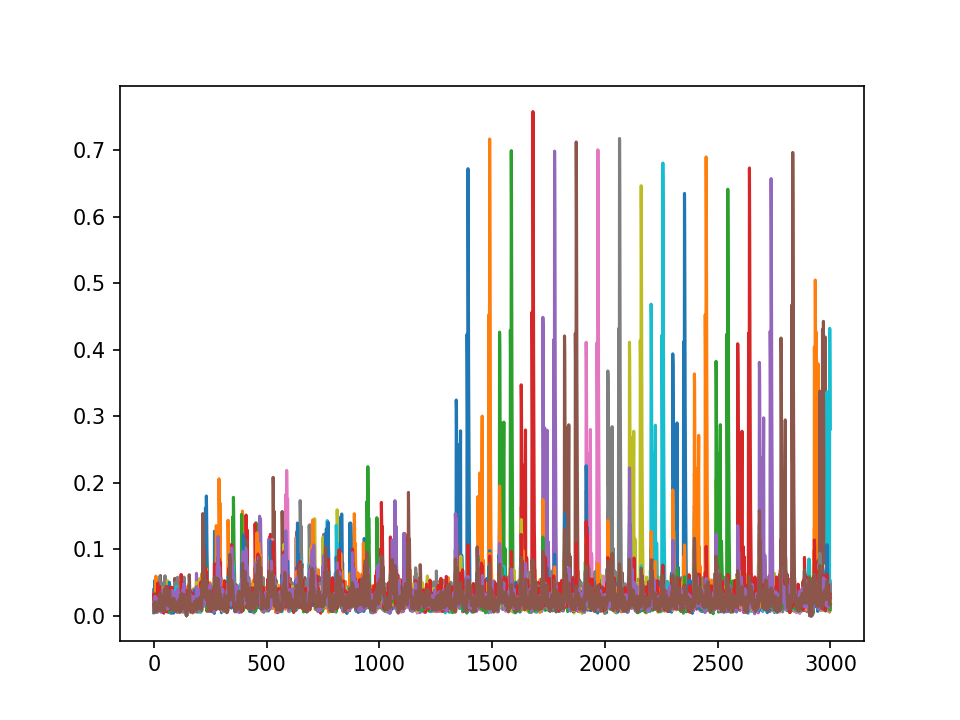

<IPython.core.display.Javascript object>


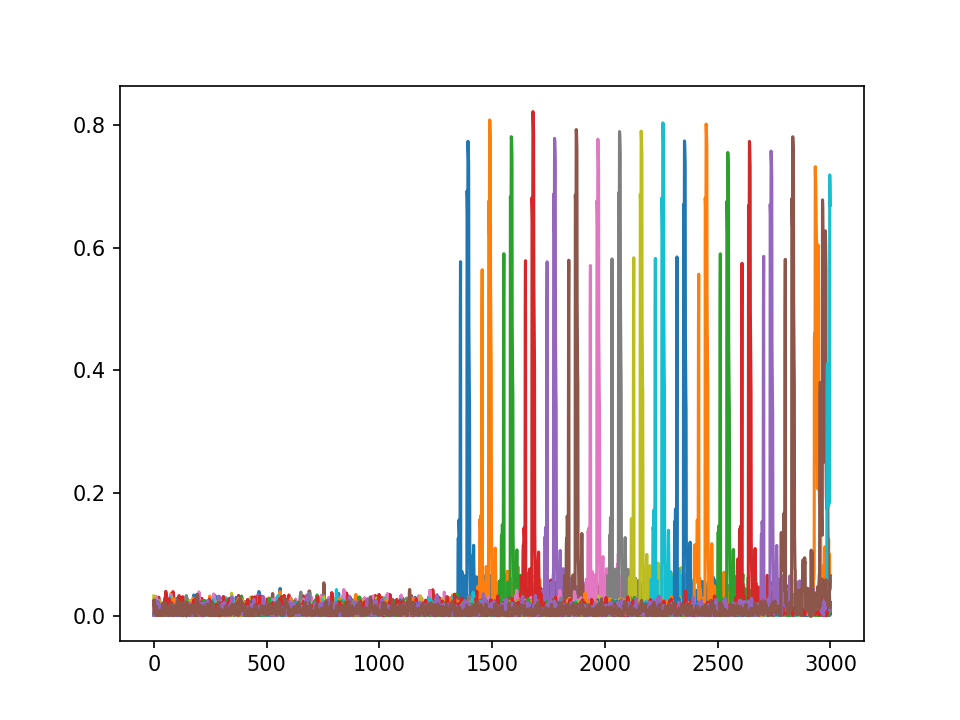

In [286]:
plot(tpl_sdif)
plot(tpl_corr)

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdDYXB0dXJpbmcgdHJhY2VzJywgbWF4PTE1LCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=



Trace length: 3000 
Text In:      226ec53b9a2d3f922b7db2655287528b 
Text Out:     fe10d248e8d1f9929cfb04dbd7055050


<IPython.core.display.Javascript object>


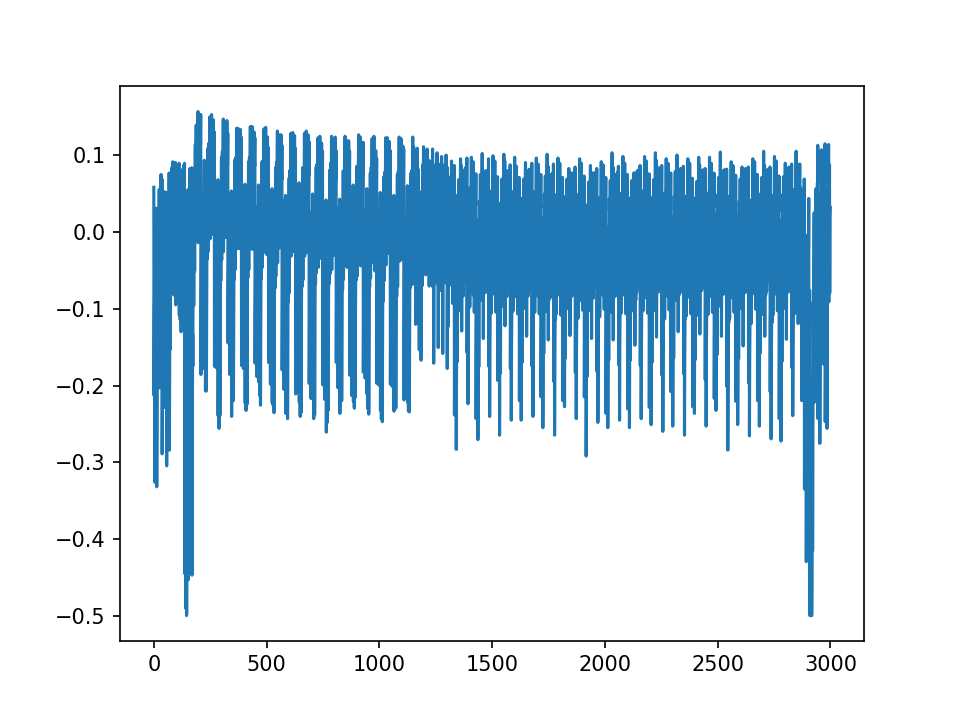

In [406]:
atk_trcs = []
atk_keys = []
atk_txis = []
atk_txos = []
target.init()
key = '{:032x}'.format(random.getrandbits(128))
keb = bytearray.fromhex(key)
for i in tnrange(15, desc='Capturing traces'):
    txi = '{:032x}'.format(random.getrandbits(128))
    (txo, trc) = getone(txi,key)
    txi = bytearray.fromhex(txi)
    atk_txis.append(np.asarray(txi, dtype=np.uint8))
    atk_txos.append(np.asarray(txo, dtype=np.uint8))
    atk_trcs.append(np.asarray(trc, dtype=np.float64))
    atk_keys.append(np.asarray(keb, dtype=np.uint8))
#Make sure we get a correct-looking trace
print('Trace length:', len(atk_trcs[0]),'\n'
      'Text In:     ', binascii.hexlify(atk_txis[0]).decode(),'\n'
      'Text Out:    ', binascii.hexlify(atk_txos[0]).decode())
plot((atk_trcs[0],))

In [407]:
tpl_dpoi = []
for i in tnrange(16):
    x = findPOIs(tpl_sdif[i],10,4,0)
    tpl_dpoi.append(x)
    print(x)
tpl_cpoi = []
for i in tnrange(16):
    x = findPOIs(tpl_corr[i],10,2,1)
    tpl_cpoi.append(x)
    print(x)
tpl_xpoi = []
for i in tnrange(16):
    x = tpl_dpoi[i] + tpl_cpoi[i]
    x = list(set(x))
    print(x)
    tpl_xpoi.append(x)

tpl_covs = []
tpl_meas = []
for i in tnrange(16, desc='Preparing template'):
    mm, mc = computeCovMatrices(tpl_hws[i], tpl_mns[i], tpl_dpoi[i])
    tpl_meas.append(mm)
    tpl_covs.append(mc)
key_guess = []
for i in tnrange(16, desc='Attacking subkeys'):
    key_guess.append(guessSubkey(i, atk_trcs, atk_txis, tpl_dpoi[i], tpl_meas[i], tpl_covs[i])[0])
bcnt = 0
for i in range(16):
    bcnt += HW[key_guess[i] ^ atk_keys[0][i]]
print('Relative-diff based POIs:')
print('Guessed key: ', ''.join('{:02x}'.format(x) for x in key_guess))
print('Expected key:', binascii.hexlify(atk_keys[0]))
print('Bits correct: %d/128'%(128-bcnt))

tpl_covs = []
tpl_meas = []
for i in tnrange(16, desc='Preparing template'):
    mm, mc = computeCovMatrices(tpl_hws[i], tpl_mns[i], tpl_cpoi[i])
    tpl_meas.append(mm)
    tpl_covs.append(mc)
key_guess = []
for i in tnrange(16, desc='Attacking subkeys'):
    key_guess.append(guessSubkey(i, atk_trcs, atk_txis, tpl_cpoi[i], tpl_meas[i], tpl_covs[i])[0])
bcnt = 0
for i in range(16):
    bcnt += HW[key_guess[i] ^ atk_keys[0][i]]
print('Correlation based POIs:')
print('Guessed key: ', ''.join('{:02x}'.format(x) for x in key_guess))
print('Expected key:', binascii.hexlify(atk_keys[0]))
print('Bits correct: %d/128'%(128-bcnt))

tpl_covs = []
tpl_meas = []
for i in tnrange(16, desc='Preparing template'):
    mm, mc = computeCovMatrices(tpl_hws[i], tpl_mns[i], tpl_xpoi[i])
    tpl_meas.append(mm)
    tpl_covs.append(mc)
key_guess = []
for i in tnrange(16, desc='Attacking subkeys'):
    key_guess.append(guessSubkey(i, atk_trcs, atk_txis, tpl_xpoi[i], tpl_meas[i], tpl_covs[i])[0])
bcnt = 0
for i in range(16):
    bcnt += HW[key_guess[i] ^ atk_keys[0][i]]
print('Combined POIs:')
print('Guessed key: ', ''.join('{:02x}'.format(x) for x in key_guess))
print('Expected key:', binascii.hexlify(atk_keys[0]))
print('Bits correct: %d/128'%(128-bcnt))

[1393, 1341, 1360, 1397, 1349, 1353, 2493, 2781, 2013, 1629]
[1489, 1456, 1493, 1445, 2397, 1917, 1437, 1629, 2301, 2493]
[1585, 1533, 1552, 1541, 1589, 2013, 1725, 1545, 1629, 2494]
[1681, 1629, 1685, 1648, 1637, 2397, 1533, 1917, 2493, 2685]
[1777, 1725, 1733, 1744, 1781, 2013, 1341, 1533, 1737, 2109]
[1873, 1821, 1840, 1829, 1877, 2301, 1533, 1833, 2685, 1629]
[1969, 1917, 1936, 1973, 1925, 1533, 1929, 2493, 1629, 2205]
[2065, 2013, 2032, 2069, 2017, 2021, 1725, 1821, 2685, 1629]
[2161, 2109, 2128, 2117, 2165, 2493, 2121, 2397, 1629, 2497]
[2257, 2205, 2224, 2261, 2209, 2213, 2109, 2301, 2397, 2013]
[2353, 2301, 2320, 2309, 2357, 1917, 1821, 2109, 2313, 1921]
[2449, 2397, 2416, 2453, 2405, 1533, 2301, 1725, 2013, 2409]
[2545, 2493, 2512, 2549, 2501, 1822, 2505, 1725, 2109, 2302]
[2641, 2589, 2608, 2645, 2598, 2593, 1341, 1917, 1921, 1629]
[2737, 2685, 2704, 2741, 2693, 2109, 1337, 1341, 2113, 2589]
[2833, 2781, 2800, 2837, 2789, 2685, 1821, 2793, 2397, 2689]



[1393, 1395, 1389, 1360, 1398, 1353, 1418, 1448, 1366, 1508]
[1489, 1491, 1485, 1456, 1494, 1449, 1514, 1474, 1616, 1567]
[1585, 1587, 1581, 1552, 1590, 1545, 1610, 1664, 1676, 1624]
[1681, 1683, 1677, 1648, 1686, 1641, 1706, 1667, 1772, 1630]
[1777, 1779, 1773, 1744, 1782, 1738, 1802, 1816, 1836, 1852]
[1873, 1875, 1869, 1840, 1878, 1833, 1898, 1988, 1944, 1859]
[1969, 1971, 1965, 1936, 1974, 1929, 2060, 1992, 2088, 2008]
[2065, 2067, 2061, 2032, 2070, 2026, 2090, 2051, 2038, 2104]
[2161, 2163, 2157, 2128, 2166, 2118, 2186, 2236, 2200, 2336]
[2257, 2259, 2253, 2224, 2262, 2217, 2282, 2328, 2292, 2364]
[2353, 2355, 2349, 2320, 2358, 2313, 2378, 2480, 2364, 2460]
[2449, 2451, 2445, 2416, 2454, 2410, 2474, 2398, 2528, 2564]
[2545, 2547, 2541, 2512, 2550, 2505, 2570, 2612, 2584, 2636]
[2641, 2643, 2637, 2608, 2646, 2601, 2666, 2591, 2720, 2768]
[2737, 2739, 2733, 2704, 2742, 2697, 2762, 2792, 2820, 2772]
[2833, 2835, 2829, 2800, 2838, 2794, 2782, 2886, 2844, 2876]



[2781, 1366, 1349, 1448, 1353, 2013, 1389, 2493, 1360, 1393, 1395, 1397, 1398, 1418, 1508, 1341, 1629]
[1616, 1474, 1445, 1449, 1514, 1485, 1491, 2397, 1456, 1489, 2301, 1493, 1494, 1437, 2493, 1917, 1629, 1567]
[1664, 1725, 1541, 1545, 1610, 1676, 1581, 1533, 1552, 1585, 1587, 1589, 1590, 2494, 1624, 2013, 1629]
[1667, 1637, 1917, 1641, 1706, 1772, 1677, 2397, 1648, 1681, 1683, 1685, 1686, 2493, 1533, 1629, 1630, 2685]
[1773, 1733, 1737, 1738, 1341, 1836, 2109, 1725, 1744, 1777, 1779, 1802, 1781, 1782, 1816, 1533, 1852, 2013]
[1859, 1988, 1829, 1833, 1898, 1869, 1821, 1840, 1873, 1875, 1877, 1878, 1944, 1533, 2301, 1629, 2685]
[1971, 1925, 1992, 1929, 2060, 1965, 1917, 1936, 1969, 2205, 1973, 1974, 2088, 2008, 2493, 1533, 1629]
[2017, 2090, 2051, 1821, 2021, 2026, 2061, 1725, 2032, 2065, 2067, 2069, 2070, 2104, 2038, 2013, 1629, 2685]
[2336, 2497, 2117, 2118, 2121, 2186, 2157, 2109, 2128, 2161, 2163, 2166, 2165, 2397, 2200, 2236, 2493, 1629]
[2262, 2209, 2213, 2259, 2217, 2013, 2253, 

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdQcmVwYXJpbmcgdGVtcGxhdGUnLCBtYXg9MTYsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb27igKY=


SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdBdHRhY2tpbmcgc3Via2V5cycsIG1heD0xNiwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXNjcmlwdGlvbl/igKY=



Relative-diff based POIs:
Guessed key:  01de7291828fa4878e6bea6ed82b579b
Expected key: 01de7291828fa4878e6bea6ed82b579b
Bits correct: 128/128


SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdQcmVwYXJpbmcgdGVtcGxhdGUnLCBtYXg9MTYsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb27igKY=


SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdBdHRhY2tpbmcgc3Via2V5cycsIG1heD0xNiwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXNjcmlwdGlvbl/igKY=



Correlation based POIs:
Guessed key:  01de7291828fa4878e6bea6ed82b579b
Expected key: 01de7291828fa4878e6bea6ed82b579b
Bits correct: 128/128


SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdQcmVwYXJpbmcgdGVtcGxhdGUnLCBtYXg9MTYsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb27igKY=


SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdBdHRhY2tpbmcgc3Via2V5cycsIG1heD0xNiwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXNjcmlwdGlvbl/igKY=


c:\program files (x86)\chipwhisperer\winpython-64bit-2.7.13.1zero\python-2.7.13.amd64\lib\site-packages\ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log



Combined POIs:
Guessed key:  01de7291828fa4878e6bea6ed82b579b
Expected key: 01de7291828fa4878e6bea6ed82b579b
Bits correct: 128/128


In [408]:
# cleanup the connection to the target and scope
scope.dis()
target.dis()
